In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time, json
import sys
sys.path.append("../")
# sys.path.append("../chess_llm_interpretability")
import os
import torch
import numpy as np

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-10-23 14:34:01 __main__ INFO     torch.__version__='2.4.1+cu121', torch.version.cuda='12.1'


In [3]:
from src.models import ModelandTokenizer

# MODEL_KEY = "meta-llama/Llama-3.2-3B-Instruct"
# MODEL_KEY = "meta-llama/Llama-3.1-8B-Instruct"

# MODEL_KEY = "meta-llama/Llama-3.2-3B"
# MODEL_KEY = "google/gemma-2-2b"
# MODEL_KEY = "meta-llama/Llama-3.1-8B"
MODEL_KEY = "meta-llama/Llama-3.2-3B"

mt = ModelandTokenizer(
    model_key=MODEL_KEY,
    # torch_dtype=torch.float32,
)

2024-10-23 14:34:02 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

2024-10-23 14:34:04 root WARNING  Some parameters are on the meta device device because they were offloaded to the cpu.
2024-10-23 14:34:04 src.models INFO     loaded model </home/local_arnab/Codes/00_MODEL/meta-llama/Llama-3.2-3B> | size: 6127.841 MB | dtype: torch.float16 | device: cuda:0


### Verify Causal Tracing

In [4]:
def get_prompt(template, examples, query):
    prompt = ""
    for w1, w2, result in examples:
        prompt += f"{template.format(w1, w2)} {result}\n"
    prompt += f"{template.format(*query)}" 
    return prompt


template = "The Spanish word \"{}\" means \"{}\" in English. This statement is:"
examples = [
    ("aire", "silver", "FALSE"),
    ("jirafa", "giraffe", "TRUE"),
    ("luz", "light", "TRUE"),
    ("mesa", "mat", "False")
]

query_base = ("uno", "floor")
prompt_base = get_prompt(template, examples, query_base)
# print(prompt_patch)

query_patch = ("uno", "one")
prompt_patch = get_prompt(template, examples, query_patch)

In [5]:
# prompt_template = "{} is located in the city of"

# clean_subj = "Louvre"
# prompt_base = prompt_template.format(clean_subj)

# patched_subj = "The Space Needle"
# prompt_patch = prompt_template.format(patched_subj)

In [6]:
from src.functional import predict_next_token

base_ans = predict_next_token(
    mt = mt, inputs = prompt_base
)[0][0]

patch_ans = predict_next_token(
    mt = mt, inputs = prompt_patch
)[0][0]

print(f"Base answer: {base_ans}")
print(f"Patch answer: {patch_ans}")

assert base_ans.token_id != patch_ans.token_id, "The answers should be different."

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/torch/_subclasses/fake_tensor.py:2039: UserWarning: Accessing the data pointer of FakeTensor is deprecated and will error in PyTorch 2.5. This is almost definitely a bug in your code and will cause undefined behavior with subsystems like torch.compile. Please wrap calls to tensor.data_ptr() in an opaque custom op; If all else fails, you can guard accesses to tensor.data_ptr() on isinstance(tensor, FakeTensor). (Triggered internally at ../c10/core/StorageImpl.cpp:31.)
  return func(*args, **kwargs)
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Base answer: " FALSE" (p=0.383)
Patch answer: " TRUE" (p=0.555)


In [38]:
from src.trace import trace_important_states

# trace_results = trace_important_states(
#     mt=mt,
#     prompt_template=prompt_template,
#     clean_subj=clean_subj,
#     patched_subj=patched_subj,
#     window_size=1
# )

trace_results = trace_important_states(
    mt=mt,
    prompt_template=prompt_base.replace(query_base[1], "{}"),
    clean_subj=query_base[1],
    patched_subj=query_patch[1],
    window_size=1,
    ignore_few_shot_examples=True,
    few_shot_delimiter="\n"
)

tensor(128000, device='cuda:0') [128000, 128001]
2024-10-23 14:50:32 src.trace DEBUG    1
The Spanish word "aire" means "silver" in English. This statement is: FALSE
The Spanish word "jirafa" means "giraffe" in English. This statement is: TRUE
The Spanish word "luz" means "light" in English. This statement is: TRUE
The Spanish word "mesa" means "mat" in English. This statement is: False
The Spanish word "uno" means "floor" in English. This statement is:
2024-10-23 14:50:32 src.trace DEBUG    trace_start_idx updated to 82
2024-10-23 14:50:32 src.trace DEBUG    82
2024-10-23 14:50:35 src.trace DEBUG    answer=PredictedToken(token=' TRUE', prob=0.5550426840782166, logit=22.734375, token_id=8378)
2024-10-23 14:50:35 src.trace DEBUG    clean_answer=PredictedToken(token=' FALSE', prob=0.38274797797203064, logit=22.15625, token_id=7989)
2024-10-23 14:50:35 src.trace DEBUG    track_ans=[(3, PredictedToken(token=' TRUE', prob=0.15707945823669434, logit=21.265625, token_id=8378))]
2024-10-23 14:

100%|██████████| 504/504 [04:21<00:00,  1.92it/s]


2024-10-23 14:55:12 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2024-10-23 14:55:12 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2024-10-23 14:55:12 matplotlib DEBUG    interactive is False
2024-10-23 14:55:12 matplotlib DEBUG    platform is linux
2024-10-23 14:55:12 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json


2024-10-23 14:55:12 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-23 14:55:12 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-10-23 14:55:12 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='norm

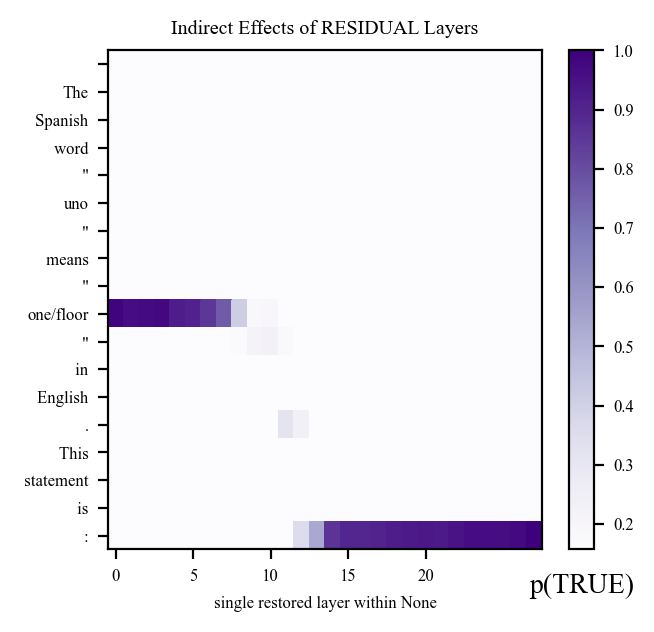

In [39]:
from src.plotting import plot_trace_heatmap

plot_trace_heatmap(trace_results)

### Dataset Parsing

In [92]:
from dataclasses import dataclass, field, fields
from dataclasses_json import DataClassJsonMixin
import random
import pandas as pd

GMT_PATH = os.path.join(env_utils.DEFAULT_DATA_DIR, "gmt")

GMT_DATA_FILES = [
    "sp_en_trans.csv",
    "cities.csv",
    "smaller_than.csv",
    "larger_than.csv",
    "common_claim_true_false.csv",
    "companies_true_false.csv",
    "counterfact_true_false.csv",
]

@dataclass(frozen=False)
class GMTDataset(DataClassJsonMixin):
    name: str
    examples: list[tuple[str, bool]] = field(default_factory=list)
    _few_shot: list | None = None
    _few_shot_prefix: str | None = None

    def __init__(
        self,
        examples: list[tuple[str, bool]],
        name: str = "GMT Dataset",
        _few_shot: list | None = None,
    ):
        self.examples = examples
        self.name = name
        self._few_shot = _few_shot

        if _few_shot is None:
            self.select_few_shot(3)
        
        logger.debug(f"initialized {self.name} with {len(self.examples)} examples.")

    def select_few_shot(self, n: int):
        if self._few_shot is not None:
            self.examples += self._few_shot
        label_dict = {True: [], False: []}
        for statement, label in self.examples:
            label_dict[label].append((statement, label))
        
        self._few_shot = []
        n_per_label = n // len(label_dict)
        n_per_label = max(1, n_per_label)

        for label in label_dict:
            if len(self._few_shot) == n:
                break
            label_examples = random.sample(label_dict[label], min(n_per_label, len(label_dict[label])))
            self._few_shot.extend(label_examples)

        self.examples = set(self.examples) - set(self._few_shot)
        self.examples = list(self.examples)

        still_needed = n - len(self._few_shot)
        if still_needed > 0:
            self._few_shot.extend(random.sample(self.examples, still_needed))

        self.examples = set(self.examples) - set(self._few_shot)
        self.examples = list(self.examples)

        
        few_shot_prefix = ""
        for statement, label in self._few_shot:
            statement, label = self.example_to_qa((statement, label))
            few_shot_prefix += f"{statement}{label}\n"
        
        self._few_shot_prefix = few_shot_prefix


    def __len__(self) -> int:
        return len(self.examples)
    
    def __getitem__(self, idx: int) -> tuple[str, str]:
        statement, label = self.examples[idx]
        statement, label = self.example_to_qa((statement, label))
        return self._few_shot_prefix + statement, label     

    @staticmethod
    def example_to_qa(
        example: tuple[str, bool]
    ) -> tuple[str, str]:
        statement, label = example
        label = " TRUE" if label else " FALSE"
        return f"{statement} This statement is:", label


    @staticmethod
    def from_csv(
        files = str | list[str],
        name: str = "GMT Dataset",
        shuffle: bool = True,
    ):
        if isinstance(files, str):
            files = [files]
        
        examples = []
        for file in files:
            file_path = os.path.join(GMT_PATH, file)
            df = pd.read_csv(file_path)
            for _, row in df.iterrows():
                examples.append((row["statement"], row["label"] == 1))
        
        if shuffle:
            random.shuffle(examples)
        return GMTDataset(examples, name)

In [93]:
ds = GMTDataset.from_csv("sp_en_trans.csv", "SP to EN")

2024-10-23 17:10:42 __main__ DEBUG    initialized SP to EN with 348 examples.


In [94]:
# ds = GMTDataset.from_csv(
#     ["sp_en_trans.csv", "cities.csv"], "SP to EN | Cities"
# )

In [97]:
ques, ans = ds[15]

print(f"\"{ques}\"")
print(f"\"{ans}\"")

"The Spanish word 'siete' means 'seven'. This statement is: TRUE
The Spanish word 'preguntar' means 'to describe'. This statement is: FALSE
The Spanish word 'calor' means 'dry'. This statement is: FALSE
The Spanish word 'escuchar' means 'market'. This statement is:"
" FALSE"


### Check separability of labels

In [101]:
predict_next_token(
    mt=mt,
    inputs=ques
)

[[PredictedToken(token=' FALSE', prob=0.8381292223930359, logit=24.75, token_id=7989),
  PredictedToken(token=' TRUE', prob=0.15747980773448944, logit=23.078125, token_id=8378),
  PredictedToken(token=' WRONG', prob=0.0005679608439095318, logit=17.453125, token_id=99760),
  PredictedToken(token=' UNKNOWN', prob=0.0005171342636458576, logit=17.359375, token_id=62495),
  PredictedToken(token=' False', prob=0.0004934529424645007, logit=17.3125, token_id=3641)]]

In [119]:
from src.functional import get_hs

inputs = prepare_input(
    prompts=ques,
    tokenizer=mt,
    return_offset_mapping=True,
)

query_end = find_token_range(
    string = ques,
    substring = ".",
    tokenizer = mt,
    occurrence = -1,
    offset_mapping=inputs["offset_mapping"][0],
)[1] - 1

query_end

64

In [129]:
last_location = (mt.layer_names[-1], -1)
interested_locations = [(layer, query_end) for layer in mt.layer_names[::2]]

In [130]:
hs = get_hs(
    mt=mt,
    input=inputs,
    locations=interested_locations + [last_location],
    return_dict=True,
)

In [132]:
from src.functional import logit_lens

logit_lens(
    mt = mt,
    h = hs[last_location],
)

[PredictedToken(token=' FALSE', prob=0.8381292223930359, logit=24.75, token_id=7989),
 PredictedToken(token=' TRUE', prob=0.15747980773448944, logit=23.078125, token_id=8378),
 PredictedToken(token=' WRONG', prob=0.0005679608439095318, logit=17.453125, token_id=99760),
 PredictedToken(token=' UNKNOWN', prob=0.0005171342636458576, logit=17.359375, token_id=62495),
 PredictedToken(token=' False', prob=0.0004934529424645007, logit=17.3125, token_id=3641)]

In [165]:
from tqdm import tqdm

@torch.inference_mode()
def get_concept_latents(
    mt: ModelandTokenizer,
    queries: list[tuple[str, str]],
    interested_layers: list[str],
):
    last_location = (mt.layer_names[-1], -1)
    all_latents = []
    for ques, ans in tqdm(queries):
        inputs = prepare_input(
            prompts=ques,
            tokenizer=mt,
            return_offset_mapping=True,
        )

        query_end = find_token_range(
            string = ques,
            substring = ".",
            tokenizer = mt,
            occurrence = -1,
            offset_mapping=inputs["offset_mapping"][0],
        )[1] - 1

        hs = get_hs(
            mt=mt,
            input=inputs,
            locations=[(layer, query_end) for layer in interested_layers] + [last_location],
            return_dict=True,
        )

        top_prediction = logit_lens(mt=mt, h=hs[last_location])[0]

        query = ques.split('\n')[-1] 
        # logger.debug(f"{query} | {top_prediction.token=} | {ans=}")
        
        if top_prediction.token != ans:
            continue
        
        latents = {layer: hs[(layer, query_end)] for layer in interested_layers}
        
        all_latents.append(dict(
            question = ques,
            question_tokenized = [mt.tokenizer.decode(t) for t in inputs["input_ids"][0]],
            answer = ans,
            prediction = top_prediction,
            query_token_idx = query_end,
            latents = latents,
        ))
    
    logger.debug(f"Collected {len(all_latents)} latents, out of {len(queries)}")

    return all_latents

In [166]:
queries = [ds[i] for i in range(len(ds))]
interested_layers = mt.layer_names[::2]

latents = get_concept_latents(mt=mt, queries=queries, interested_layers=interested_layers)

  0%|          | 0/348 [00:00<?, ?it/s]

100%|██████████| 348/348 [09:41<00:00,  1.67s/it]

2024-10-23 18:11:13 __main__ DEBUG    Collected 346 latents, out of 348


In [167]:
latents[0]["latents"][interested_layers[0]]

tensor([ 0.0074, -0.0203, -0.0809,  ...,  0.0157,  0.0102,  0.0151],
       device='cuda:0', dtype=torch.float16)

In [168]:
len(ds)

348

In [176]:
def get_pcs(X, k=2, offset=0):
    """
    Performs Principal Component Analysis (PCA) on the n x d data matrix X. 
    Returns the k principal components, the corresponding eigenvalues and the projected data.
    """

    # Subtract the mean to center the data
    X = X - torch.mean(X, dim=0)
    
    # Compute the covariance matrix
    cov_mat = torch.mm(X.t(), X) / (X.size(0) - 1)
    
    # Perform eigen decomposition
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_mat)
    
    # Since the eigenvalues and vectors are not necessarily sorted, we do that now
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the pcs
    eigenvectors = eigenvectors[:, offset:offset+k]
    
    return eigenvectors

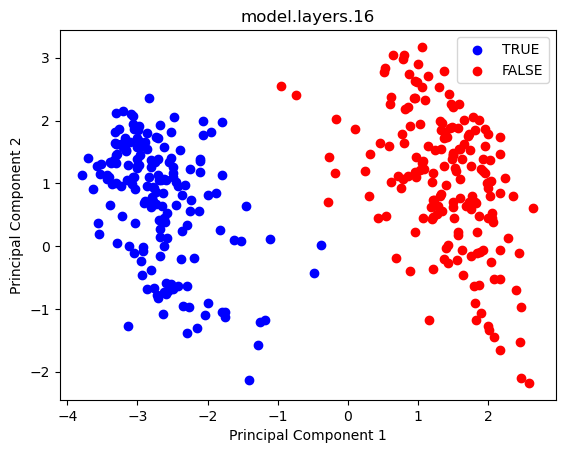

In [208]:
layer = interested_layers[8]

X = torch.stack([l["latents"][layer] for l in latents]).to(torch.float32).to("cuda")
pcs = get_pcs(X, k=2)
X2 = X @ pcs

y = [l["answer"] for l in latents]

import matplotlib.pyplot as plt

true_points = []
false_points = []

for point, label in zip(X2, y):
    if label == " TRUE":
        true_points.append(point.cpu())
    else:
        false_points.append(point.cpu())

true_points = np.array(true_points)
false_points = np.array(false_points)

plt.scatter(true_points[:, 0], true_points[:, 1], color='blue', label='TRUE')
plt.scatter(false_points[:, 0], false_points[:, 1], color='red', label='FALSE')

plt.legend()
plt.title(layer)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()
